# Estimate y errors of spectra in arbitrary units

Idea by Ludmil Tsankov

## Spectrum generation

In [1]:
from ramanchada2 import spectrum
from ramanchada2.spectral_components import GaussPeak, SpectralComponentCollection
import scipy.stats
import scipy.optimize
import numpy as np
import matplotlib.pyplot as plt

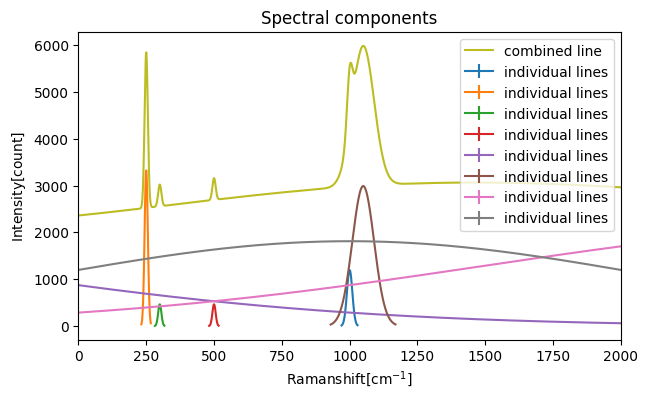

In [2]:
spe_coll = SpectralComponentCollection([
    GaussPeak(a=50000, x0=250, w=6),
    GaussPeak(a=7000, x0=300, w=6),
    GaussPeak(a=7000, x0=500, w=6),
    GaussPeak(a=30000, x0=1000, w=10),
    GaussPeak(a=300000, x0=1050, w=40),
    GaussPeak(a=8000000, x0=3000, w=1500),
    GaussPeak(a=5000000, x0=1000, w=1100),
    GaussPeak(a=8000000, x0=-2000, w=1500),
])
fig, ax = plt.subplots(1, figsize=(7, 4))
spe_coll.plot(ax=ax, draw='individual lines', label='individual lines')
spe_coll.plot(ax=ax, draw='combined line', label='combined line')
ax.set_xlim(0, 2000)
ax.set_title('Spectral components')
ax.set_xlabel('$\mathrm{Raman shift [cm^{-1}]}$')
_ = ax.set_ylabel('$\mathrm{Intensity [count]}$')

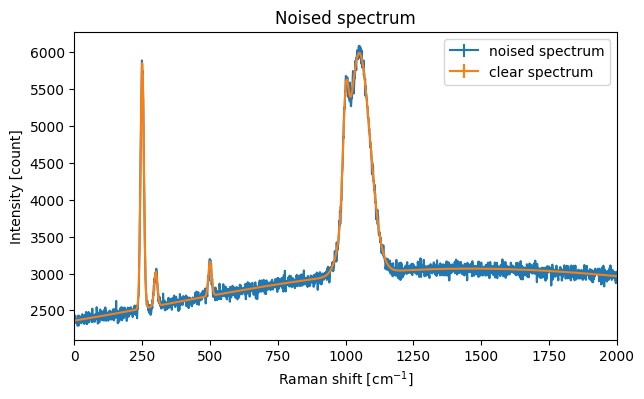

In [3]:
spe_clear = spectrum.from_spectral_component_collection(x=2000, spe_components=spe_coll)
spe_noise = spe_clear.add_poisson_noise()
fig, ax = plt.subplots(1, figsize=(7, 4))
spe_noise.plot(ax=ax, label='noised spectrum')
spe_clear.plot(ax=ax, label='clear spectrum')
ax.set_xlim(0, 2000)
ax.set_title('Noised spectrum')
ax.set_xlabel('Raman shift $\mathrm{[cm^{-1}]}$')
_ = ax.set_ylabel('Intensity [count]')

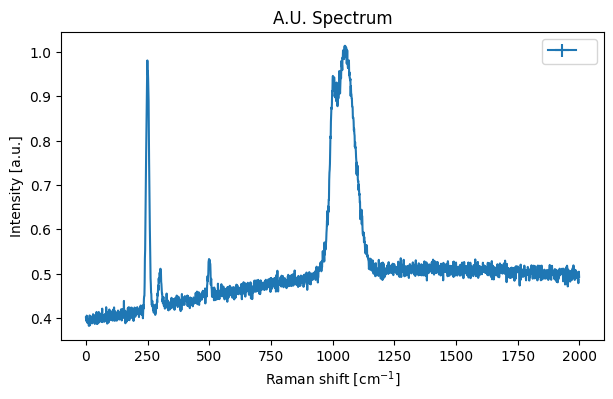

In [4]:
spe_au = spe_noise.scale_yaxis_linear(factor=1/6000)
fig, ax = plt.subplots(1, figsize=(7, 4))
spe_au.plot(ax=ax)
ax.set_title('A.U. Spectrum')
ax.set_xlabel('Raman shift $\mathrm{[cm^{-1}]}$')
_ = ax.set_ylabel('Intensity [a.u.]')

In [5]:
spe_au.y

array([0.4005629008852857, 0.3931758224854841, 0.3967280004351365, ...,
       0.4914384887147293, 0.5041398742085311, 0.4925601403837674],
      dtype=object)

In [6]:
from scipy import signal, fft
def spline(s):
    res = np.zeros_like(s)
    sig2 = np.zeros_like(s)
    for i in [0, 1, -2, -1]:
        res[i] = s[i]
        sig2[i] = 0
    for i in range(2, len(res)-2):
        res[i] = 1/6*(-s[i-2] + 4*s[i-1] + 4*s[i+1] - s[i+2])
        sig2[i] = 1/36*(-s[i-2] + 16*s[i-1] + 16*s[i+1] - s[i+2])
    return res, sig2
def spline_sma(s):
    res = np.zeros_like(s)
    sig2 = np.zeros_like(s)
    for i in [0, 1, -2, -1]:
        res[i] = s[i]
        sig2[i] = 0
    for i in range(2, len(res)-2):
        res[i] = 1/4*(s[i-2] + s[i-1] + s[i+1] + s[i+2])
        sig2[i] = 1/16*(s[i-2] + s[i-1] + s[i+1] + s[i+2])
    return res, sig2
def low_pass(s, width):
    S = fft.rfft(s)
    w = signal.windows.hann(width)[(width+1)//2-1:]
    w = np.concatenate((w, np.zeros(len(S)-len(w))))
    ss = fft.irfft(S*w)
    #import ipdb as pdb; pdb.set_trace()
    return ss, np.sqrt(ss)


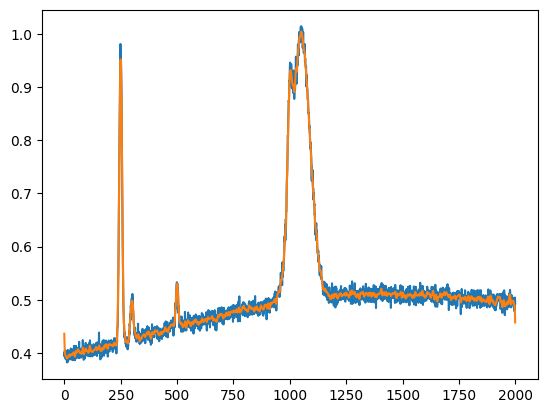

In [7]:
ys, _ = low_pass(spe_au.y, 900)
plt.plot(spe_au.y)
plt.plot(ys)

In [8]:
coef = list()
for i in range(200):
    spe_clear = spectrum.from_spectral_component_collection(x=2000, spe_components=spe_coll)
    spe_noise = spe_clear.add_poisson_noise()
    spe_au = spe_noise.scale_yaxis_linear(factor=1/6000)

    spe_au_smooth_y, spe_au_smooth_sig2 = spline_sma(spe_au.y)

    rr = (spe_au.y - spe_au_smooth_y)/ np.sqrt(spe_au.y+spe_au_smooth_sig2)
    coef.append(1/np.var(rr))

TypeError: loop of ufunc does not support argument 0 of type float which has no callable sqrt method

In [ ]:
fig, ax = plt.subplots(1, figsize=(12,5))
ax.hist(coef, bins=50)
None

In [ ]:
np.mean(coef), np.std(coef)